# Content

# Project Description

You are an analyst at Megaline, a federal mobile operator. Customers are offered two tariff plans: "Smart" and "Ultra". To adjust the advertising budget, the commercial department wants to understand which tariff brings in more money.
You will have to make a preliminary analysis of tariffs on a small sample of customers. You have the data of 500 Megalyne users at your disposal: who they are, where they come from, what tariff they use, how many calls and messages each sent in 2018. It is necessary to analyze the behavior of customers and conclude which tariff is better.

## Description of tariffs

#### Smart tariff
Monthly fee: 550 rubles

Included 500 minutes of conversation, 50 messages and 15 GB of Internet traffic

The cost of services in excess of the tariff package:

    minute of conversation: 3 rubles
    message: 3 rubles
    1 GB of Internet traffic: 200 rubles

#### Tariff "Ultra"
Monthly fee: 1950 rubles

3000 minutes of conversation, 1000 messages and 30 GB of Internet traffic are included

The cost of services in excess of the tariff package:

    minute of conversation: 1 ruble
    message: 1 ruble
    1 GB of Internet traffic: 150 rubles

In [1]:
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import math 

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv').drop(['Unnamed: 0'],axis = 1)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

# EDA

### Processing of zero values (omissions)

In order not to call the info method for each dataframe, we will create a function that will process the necessary information and combine everything into one table

In [3]:
for data in [calls, internet, messages, users, tariffs]: 
    print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-N

Note that only a single column has the missing values "churn_date". To process these values, you need to change the data type

In [4]:
columns_to_datetime = {"reg_date":users,
                       "message_date":messages,
                       "session_date":internet,
                       "call_date":calls}

for column, data in columns_to_datetime.items():
    data[column] = pd.to_datetime(data[column],format = '%Y-%m-%d')

#### Fill the nan values

The average life expectancy in Russia is 71.5 years. Add to the current date the difference between the average age and the age of the subscriber and fill in the gaps with this value

In [5]:
def fillna_churn_date(row):
    if pd.isnull(row["churn_date"]):
        mean_ages = 100
        delta = mean_ages - row['age'] 
        date = str(2022 + delta)+'-01-01' #возьмем первое число первого месяца
        row["churn_date"] = pd.to_datetime(date,format = '%Y-%m-%d')
    return row

In [6]:
users = users.apply(fillna_churn_date, axis = 1)

After combining the data (a summary table for calls, messages and Internet traffic), missing values will appear (the client could not write messages in some month, but call and use the Internet), which will also need to be replaced with zeros.
## Checking for duplicates

In [7]:
all_table = [calls, internet, messages, tariffs, users]

In [8]:
for table in all_table:
    print(table.duplicated().sum())

0
0
0
0
0


## Add a column with the month value

In [9]:
calls['month'] = calls["call_date"].dt.month

Let's plot the dependence of the number of zero values on the total number of calls for each month

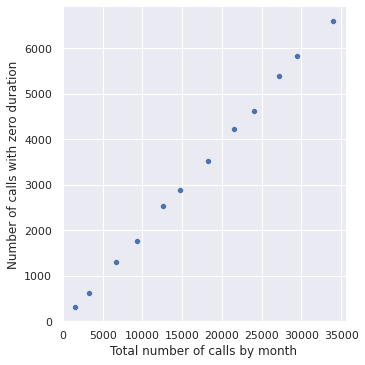

In [10]:
calls.loc[calls['duration'] == 0, 'nulls_count'] = 1
null_calls = calls.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')
null_calls['null_ratio'] = round(null_calls['nulls_count'] / null_calls['id'], 3)

sns.relplot(x='id', y='nulls_count', data=null_calls)
plt.xlabel('Total number of calls by month')
plt.ylabel('Number of calls with zero duration');


In [11]:
calls['duration'] = np.ceil(calls['duration'])

calls.loc[calls['duration'] == 0, 'duration'] = 1

In [12]:
calls['duration']

0          1.0
1          1.0
2          3.0
3         14.0
4          6.0
          ... 
202602     1.0
202603    19.0
202604    11.0
202605     5.0
202606    20.0
Name: duration, Length: 202607, dtype: float64

### Add a column with the month value

In [13]:
internet['month'] = internet['session_date'].dt.month

Let's plot the dependence of the number of zero values on the total number of Internet sessions for each month

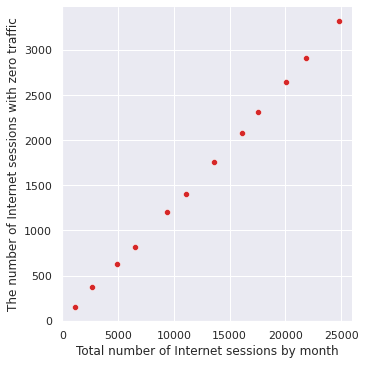

In [14]:
internet.loc[internet['mb_used'] == 0, 'nulls_count'] = 1

null_mb = internet.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')

null_mb['null_ratio'] = round(null_mb['nulls_count'] / null_mb['id'], 3)

sns.relplot(x='id', y='nulls_count', data=null_mb, color='tab:red')
plt.xlabel('Total number of Internet sessions by month')
plt.ylabel('The number of Internet sessions with zero traffic');

In [15]:
messages['month'] = messages["message_date"].dt.month

# Changing the data type

In [16]:
int_types = ["uint8", "int8", "int16"]
for it in int_types:
    print(np.iinfo(it))

Machine parameters for uint8
---------------------------------------------------------------
min = 0
max = 255
---------------------------------------------------------------

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------



#### Table calls

In [17]:
for dtype in ['float','int','object']:
    selected_dtype = calls.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))


Average memory usage for float columns: 1.03 MB
Average memory usage for int columns: 1.03 MB
Average memory usage for object columns: 6.26 MB


In [18]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # исходим из предположения о том, что если это не DataFrame, то это Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # преобразуем байты в мегабайты
    return "{:03.2f} MB".format(usage_mb)

df_int = calls.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(df_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

3.09 MB
0.58 MB


,before,after
uint8,NaN,1.0
uint16,NaN,1.0
int64,2.0,NaN


In [19]:
df_float = calls.select_dtypes(include=['float'])
converted_float = df_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(df_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([df_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

3.09 MB
1.55 MB


,before,after
float32,NaN,2.0
float64,2.0,NaN


In [20]:
optimized_df = calls.copy()

optimized_df[converted_int.columns] = converted_int
optimized_df[converted_float.columns] = converted_float

print(mem_usage(calls))
print(mem_usage(optimized_df))

20.24 MB
16.18 MB


In [21]:
df_obj = calls.select_dtypes(include=['object']).copy()
df_obj.describe().T

,count,unique,top,freq
id,202607,202607,1057_114,1


In [22]:
converted_obj = pd.DataFrame()
optimized_df[converted_obj.columns] = converted_obj

mem_usage(optimized_df)

'16.18 MB'

In [23]:
calls = optimized_df

In [24]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           202607 non-null  object        
 1   call_date    202607 non-null  datetime64[ns]
 2   duration     202607 non-null  float32       
 3   user_id      202607 non-null  uint16        
 4   month        202607 non-null  uint8         
 5   nulls_count  39613 non-null   float32       
dtypes: datetime64[ns](1), float32(2), object(1), uint16(1), uint8(1)
memory usage: 5.2+ MB


#### Table internet

In [25]:
for dtype in ['float','int','object']:
    selected_dtype = internet.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))


Average memory usage for float columns: 0.76 MB
Average memory usage for int columns: 0.76 MB
Average memory usage for object columns: 4.61 MB


In [26]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # исходим из предположения о том, что если это не DataFrame, то это Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # преобразуем байты в мегабайты
    return "{:03.2f} MB".format(usage_mb)

df_int = internet.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(df_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

2.28 MB
0.43 MB


,before,after
uint8,NaN,1.0
uint16,NaN,1.0
int64,2.0,NaN


In [27]:
df_float = internet.select_dtypes(include=['float'])
converted_float = df_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(df_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([df_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

2.28 MB
1.14 MB


,before,after
float32,NaN,2.0
float64,2.0,NaN


In [28]:
optimized_df = internet.copy()

optimized_df[converted_int.columns] = converted_int
optimized_df[converted_float.columns] = converted_float

print(mem_usage(internet))
print(mem_usage(optimized_df))

14.91 MB
11.92 MB


In [29]:
df_obj = internet.select_dtypes(include=['object']).copy()
df_obj.describe().T

,count,unique,top,freq
id,149396,149396,1250_279,1


In [30]:
converted_obj = pd.DataFrame()
optimized_df[converted_obj.columns] = converted_obj

mem_usage(optimized_df)

'11.92 MB'

In [31]:
internet = optimized_df

In [32]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float32       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  uint16        
 4   month         149396 non-null  uint8         
 5   nulls_count   19598 non-null   float32       
dtypes: datetime64[ns](1), float32(2), object(1), uint16(1), uint8(1)
memory usage: 3.8+ MB


#### Table messages

In [33]:
for dtype in ['float','int','object']:
    selected_dtype = messages.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 0.00 MB
Average memory usage for int columns: 0.63 MB
Average memory usage for object columns: 3.80 MB


In [34]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # исходим из предположения о том, что если это не DataFrame, то это Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # преобразуем байты в мегабайты
    return "{:03.2f} MB".format(usage_mb)

df_int = messages.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(df_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

1.88 MB
0.35 MB


,before,after
uint8,NaN,1.0
uint16,NaN,1.0
int64,2.0,NaN


In [35]:
optimized_df = messages.copy()

optimized_df[converted_int.columns] = converted_int


print(mem_usage(messages))
print(mem_usage(optimized_df))

10.41 MB
8.88 MB


In [36]:
df_obj = messages.select_dtypes(include=['object']).copy()
df_obj.describe().T

,count,unique,top,freq
id,123036,123036,1052_435,1


In [37]:
converted_obj = pd.DataFrame()

optimized_df[converted_obj.columns] = converted_obj

mem_usage(optimized_df)

'8.88 MB'

In [38]:
messages = optimized_df

In [39]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  uint16        
 3   month         123036 non-null  uint8         
dtypes: datetime64[ns](1), object(1), uint16(1), uint8(1)
memory usage: 2.2+ MB


#### Table tariffs

In [40]:
for dtype in ['float','int','object']:
    selected_dtype = tariffs.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 8
    print("Average memory usage for {} columns: {:03.2f} B".format(dtype,mean_usage_mb))


Average memory usage for float columns: 16.00 B
Average memory usage for int columns: 3.75 B
Average memory usage for object columns: 15.75 B


In [41]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # исходим из предположения о том, что если это не DataFrame, то это Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 8 # преобразуем байты в мегабайты
    return "{:03.2f} B".format(usage_mb)

df_int = tariffs.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(df_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

30.00 B
18.75 B


,before,after
uint8,NaN,3.0
uint16,NaN,4.0
int64,7.0,NaN


In [42]:
optimized_df = tariffs.copy()

optimized_df[converted_int.columns] = converted_int

print(mem_usage(tariffs))
print(mem_usage(optimized_df))

45.50 B
34.25 B


In [43]:
df_obj = tariffs.select_dtypes(include=['object']).copy()
df_obj.describe().T

,count,unique,top,freq
tariff_name,2,2,smart,1


In [44]:
converted_obj = pd.DataFrame()

optimized_df[converted_obj.columns] = converted_obj

mem_usage(optimized_df)

'34.25 B'

In [45]:
tariffs = optimized_df

In [46]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      uint16
 1   mb_per_month_included  2 non-null      uint16
 2   minutes_included       2 non-null      uint16
 3   rub_monthly_fee        2 non-null      uint16
 4   rub_per_gb             2 non-null      uint8 
 5   rub_per_message        2 non-null      uint8 
 6   rub_per_minute         2 non-null      uint8 
 7   tariff_name            2 non-null      object
dtypes: object(1), uint16(4), uint8(3)
memory usage: 166.0+ bytes


#### Table users

In [47]:
for dtype in ['float','int','object']:
    selected_dtype = users.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 8
    print("Average memory usage for {} columns: {:03.2f} B".format(dtype,mean_usage_mb))

Average memory usage for float columns: 16.00 B
Average memory usage for int columns: 338.67 B
Average memory usage for object columns: 4997.90 B


In [48]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # исходим из предположения о том, что если это не DataFrame, то это Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 8 # преобразуем байты в мегабайты
    return "{:03.2f} B".format(usage_mb)

df_int = users.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(df_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

1016.00 B
203.50 B


,before,after
uint8,NaN,1.0
uint16,NaN,1.0
int64,2.0,NaN


In [49]:
df_float = users.select_dtypes(include=['float'])
converted_float = df_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(df_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([df_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

16.00 B
16.00 B


,before,after


In [50]:
optimized_df = users.copy()

optimized_df[converted_int.columns] = converted_int
optimized_df[converted_float.columns] = converted_float

print(mem_usage(users))
print(mem_usage(optimized_df))

26989.50 B
26177.00 B


Хотя мы значительно уменьшили потребление памяти столбцами, хранящими числовые данные, в целом, по всему объекту DataFrame, потребление памяти снизилось лишь на 7%. Источником куда более серьёзного улучшения ситуации может стать оптимизация хранения объектных типов.

In [51]:
df_obj = users.select_dtypes(include=['object']).copy()
df_obj.describe().T

,count,unique,top,freq
city,500,76,Москва,99
first_name,500,246,Радим,6
last_name,500,419,Андреенко,5
tariff,500,2,smart,351


In [52]:
converted_obj = pd.DataFrame()

for col in df_obj.columns:
    num_unique_values = len(df_obj[col].unique())
    num_total_values = len(df_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = df_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_obj[col]

In [53]:
print(mem_usage(df_obj))
print(mem_usage(converted_obj))

compare_obj = pd.concat([df_obj.dtypes,converted_obj.dtypes],axis=1)
compare_obj.columns = ['before','after']
compare_obj.apply(pd.Series.value_counts)

24989.50 B
13121.38 B


,before,after
object,4.0,1
category,NaN,1
category,NaN,1
category,NaN,1


In [54]:
optimized_df[converted_obj.columns] = converted_obj

mem_usage(optimized_df)

'14308.88 B'

In [55]:
users = optimized_df

In [56]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    uint16        
 1   age         500 non-null    uint8         
 2   churn_date  500 non-null    datetime64[ns]
 3   city        500 non-null    category      
 4   first_name  500 non-null    category      
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    category      
dtypes: category(3), datetime64[ns](2), object(1), uint16(1), uint8(1)
memory usage: 28.1+ KB


### Output
There are no gaps in the tables, the data types are adjusted (columns of dates and integer values). In the users table, the char_date column was filled with an average value for life expectancy so that the correct data type could be entered. The rounding in the signs duration and volume for calls and Internet traffic is made in a big way, according to the conditions of this operator, rounding occurs when reading the use of the packet in a large fold with a minimum accounting unit of a second - time, Mb - Internet.

# Statistics

We will find for each user:
* number of calls made and minutes spent 
* conversations by month;
* number of messages sent by month;
* the amount of Internet traffic consumed by month.

### Call Summary table

In [57]:
calls_temp = calls.merge(users, on='user_id', how='inner')
calls_grouped = calls_temp.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])
calls_grouped.columns = ['calls', 'duration']

In [58]:
calls_grouped 

calls  duration
user_id month                 
1000    5         22     164.0
        6         43     187.0
        7         47     346.0
        8         52     418.0
        9         58     478.0
...              ...       ...
1498    10        41     258.0
1499    9          9      71.0
        10        68     473.0
        11        74     624.0
        12        69     505.0

[3174 rows x 2 columns]

### Summary table by messages

In [59]:
messages_temp = messages.merge(users, on='user_id', how='inner')
messages_grouped = messages_temp.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count')
messages_grouped.columns = ['messages']

In [60]:
messages_grouped

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
...                 ...
1498    10           42
1499    9            11
        10           48
        11           59
        12           66

[2717 rows x 1 columns]

### Summary table of Internet traffic

In [61]:
internet_temp = internet.merge(users, on='user_id', how='inner')
internet_grouped = internet_temp.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_grouped.columns = ['mb_used']

In [62]:
internet_grouped['gb_used'] = np.ceil(internet_grouped['mb_used']/1024).astype('int')
internet_grouped.loc[internet_grouped['gb_used'] == 0, 'gb_used'] = 1

In [63]:
internet_grouped

mb_used  gb_used
user_id month                       
1000    5       2253.489990        3
        6      23233.769531       23
        7      14003.639648       14
        8      14055.929688       14
        9      14568.910156       15
...                     ...      ...
1498    10     20579.359375       21
1499    9       1845.750000        2
        10     17788.509766       18
        11     17963.310547       18
        12     13055.580078       13

[3203 rows x 2 columns]

In [64]:
internet_grouped.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3203 entries, (1000, 5) to (1499, 12)
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mb_used  3203 non-null   float32
 1   gb_used  3203 non-null   int64  
dtypes: float32(1), int64(1)
memory usage: 51.0 KB


### Combine all three pivot tables into one

In [65]:
df = calls_grouped.join([messages_grouped, internet_grouped], how='outer')

In [66]:
df.head(10)

calls  duration  messages       mb_used  gb_used
user_id month                                                  
1000    5       22.0     164.0      22.0   2253.489990      3.0
        6       43.0     187.0      60.0  23233.769531     23.0
        7       47.0     346.0      75.0  14003.639648     14.0
        8       52.0     418.0      81.0  14055.929688     14.0
        9       58.0     478.0      57.0  14568.910156     15.0
        10      57.0     363.0      73.0  14702.490234     15.0
        11      43.0     344.0      58.0  14756.469727     15.0
        12      46.0     341.0      70.0   9817.610352     10.0
1001    11      59.0     444.0       NaN  18429.339844     18.0
        12      63.0     430.0       NaN  14036.660156     14.0

In [67]:
df = df.join(users.loc[:,['user_id', 'tariff']].set_index('user_id'), how='outer')

As a result, we get a complete summary table in which the number of calls, the duration of calls, Internet sessions and the number of SMS messages, as well as the tariff, are indicated for each user by month.

However, earlier we could notice that all tables have a different number of rows. 

This is due to the fact that some users did not have information on specific months, for example, they could not send a single message per month, or not go online. 

This means that there are gaps in our summary table.

Filled them with zeros, based on the logic that the user did not perform any actions during a certain period.

In [68]:
df['duration'].fillna(0, inplace=True)
df['duration'].isnull().sum()

0

In [69]:
df['calls'].fillna(0, inplace=True)
df['calls'].isnull().sum()

0

In [70]:
df['messages'].fillna(0, inplace=True)
df['messages'].isnull().sum()

0

In [71]:
df['mb_used'].fillna(0, inplace=True)
df['mb_used'].isnull().sum()

0

Our summary table is ready to calculate monthly revenue. To calculate revenue, it is necessary for each user to subtract the free limit from the total number of calls, messages and Internet traffic, and multiply the remainder by the value from the tariff plan. You also need to add a monthly subscription fee to the amount.

Let's declare the total_income_per_month_calculation function, which will return the total revenue for each user per month. To calculate revenue, it is necessary to add an additional fee to the subscription fee for minutes, messages and traffic that has exceeded the limits.

In [72]:
df.head(10)

calls  duration  messages       mb_used  gb_used tariff
user_id month                                                         
1000    5       22.0     164.0      22.0   2253.489990      3.0  ultra
        6       43.0     187.0      60.0  23233.769531     23.0  ultra
        7       47.0     346.0      75.0  14003.639648     14.0  ultra
        8       52.0     418.0      81.0  14055.929688     14.0  ultra
        9       58.0     478.0      57.0  14568.910156     15.0  ultra
        10      57.0     363.0      73.0  14702.490234     15.0  ultra
        11      43.0     344.0      58.0  14756.469727     15.0  ultra
        12      46.0     341.0      70.0   9817.610352     10.0  ultra
1001    11      59.0     444.0       0.0  18429.339844     18.0  smart
        12      63.0     430.0       0.0  14036.660156     14.0  smart

In [73]:
def total_income_per_month_calculation(row):

    calls = row['calls']
    duration = row['duration']
    gb_used = row['mb_used']
    messages = row['messages']
    tariff = row['tariff']
    

    megabytes_included = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['mb_per_month_included'])
    messages_included = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['messages_included'])
    minutes_included = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['minutes_included'])
    monthly_fee = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['rub_monthly_fee'])
    price_for_gb = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['rub_per_gb'])
    price_for_message = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['rub_per_message'])
    price_for_minute = int(tariffs.loc[tariffs.loc[:,'tariff_name'] == tariff]['rub_per_minute'])
    
    over_gb = 0               
    over_msg = 0               
    over_calls = 0             
    

    
    gb_used = row['gb_used']

    if gb_used > (megabytes_included/1024):
        over_gb = (gb_used - megabytes_included/1024) * price_for_gb
    

    if duration > minutes_included:
        over_calls = (duration - minutes_included) * price_for_minute
        
    if messages > messages_included:
        over_msg = (messages - messages_included) * price_for_message 
    

    return over_gb + over_msg + over_calls + monthly_fee

In [74]:
df['total_income'] = df.apply(total_income_per_month_calculation, axis = 1)

In [75]:
df.drop(columns = ['mb_used'],axis = 1).head(10)

calls  duration  messages  gb_used tariff  total_income
user_id month                                                         
1000    5       22.0     164.0      22.0      3.0  ultra        1950.0
        6       43.0     187.0      60.0     23.0  ultra        1950.0
        7       47.0     346.0      75.0     14.0  ultra        1950.0
        8       52.0     418.0      81.0     14.0  ultra        1950.0
        9       58.0     478.0      57.0     15.0  ultra        1950.0
        10      57.0     363.0      73.0     15.0  ultra        1950.0
        11      43.0     344.0      58.0     15.0  ultra        1950.0
        12      46.0     341.0      70.0     10.0  ultra        1950.0
1001    11      59.0     444.0       0.0     18.0  smart        1150.0
        12      63.0     430.0       0.0     14.0  smart         550.0

In [76]:
df['total_income'].max()

6824.0

## Output

At the stage of data preprocessing, we tried to remove the shortcomings identified at the stage of studying general information:

  The data type was changed from object to datetime64 for all columns containing the date.
    
   The values of the minutes of the conversation and the traffic spent were rounded up.
    
   The missing values in the 'churn_date' column in the users table were not filled in, due to the fact that these data are not used in further analysis, as well as based on the logic that unfilled values mean that the user is still using the tariff.
    
   It was decided not to change or delete the zero values in the columns with the duration of the conversation and the traffic used, based on the logic that zeros mean either missed calls or an incorrectly recorded Internet session.
    
   An extra column was removed from the internet dataframe.
   
   Columns with the month value were added to the calls, internet, messages dataframes.
    
   A summary general table was created in which the sum of the duration of conversations, messages sent and traffic consumed for each user by month was calculated.
    
   The monthly revenue from each user was calculated.
    
   Such data preprocessing will allow us to conduct a quick and informative data analysis, calculate the main statistical characteristics, as well as test hypotheses.

# Data analysis

In [77]:
medians_per_month = df.pivot_table(index='user_id', 
                        values=['duration', 'gb_used', 'messages'], 
                        aggfunc='median')

In [78]:
medians_per_month.join(users.loc[:,['user_id', 'tariff']].set_index('user_id'), how='outer').head()

,duration,gb_used,messages,tariff
user_id,,,,
1000,345.0,14.5,65.0,ultra
1001,437.0,16.0,0.0,smart
1002,221.0,18.0,11.0,smart
1003,844.0,12.0,83.0,ultra
1004,136.5,18.0,154.5,ultra


In [79]:
statistics = df.pivot_table(index=['tariff'], values=['duration', 'gb_used', 'messages'], 
                    aggfunc={'duration': [np.mean, np.median, np.var, np.std], 
                             'gb_used': [np.mean, np.median, np.var, np.std], 
                             'messages': [np.mean, np.median, np.var, np.std]})
statistics.applymap("{:.1f}".format) #округлим выводимые значения используя format

duration                         gb_used                   messages  \
           mean median    std       var    mean median  std   var     mean   
tariff                                                                       
smart     429.5  435.0  194.9   37974.8    16.3   17.0  5.7  32.9     33.4   
ultra     540.8  532.0  325.7  106105.7    19.7   19.0  9.7  94.1     49.4   

                             
       median   std     var  
tariff                       
smart    28.0  28.2   796.8  
ultra    38.0  47.8  2285.3

## Output

The following conclusions can be drawn from the indicators:

On average, a smart user speaks **430 minutes** per month, and an ultra user speaks **532 minutes**.

On average, a smart user uses **16.3 gb.** of traffic, and an ultra tariff user uses **19 GB**.

On average, the smart user sends **28 messages**, and the user of the ultra tariff - **38** .
The variance of the ultra tariff is greater than that of the smart tariff, which tells us about a larger range of values.

In general, users ** of the "Ultra" tariff use the operator's services more freely **, they talk more, spend more time on the Internet, send more messages, while the average user does not exceed the tariff limits. On the other hand, the average ** user of the "Smart" tariff has to buy 1 GB of traffic in excess of the limit **.

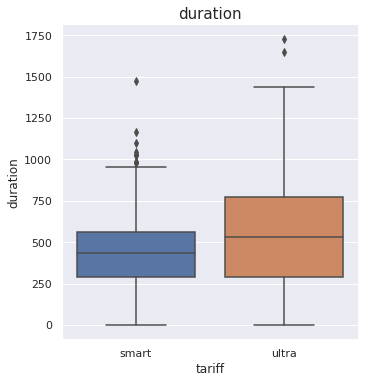

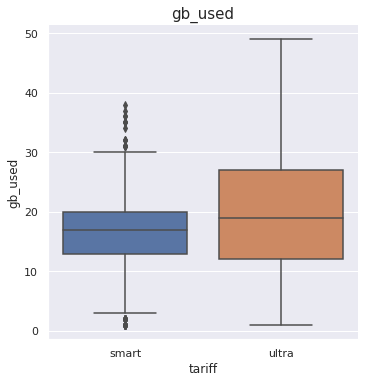

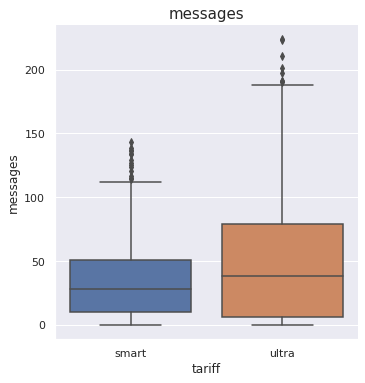

In [80]:
for column in ['duration', 'gb_used', 'messages']:
    sns.catplot(x='tariff', y=column, data=df, kind='box')
    plt.title(column, fontsize=15)

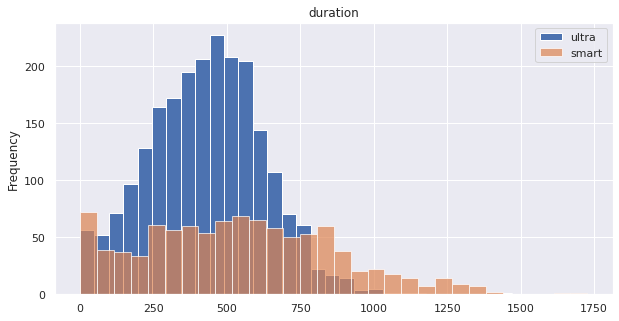

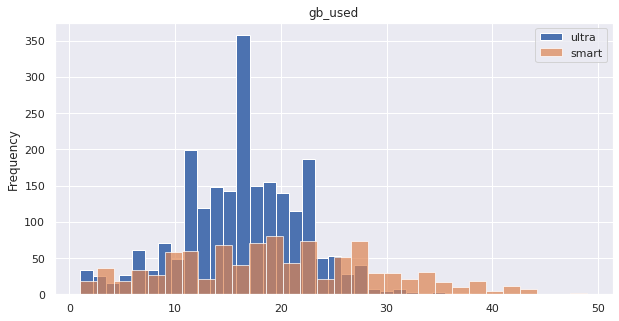

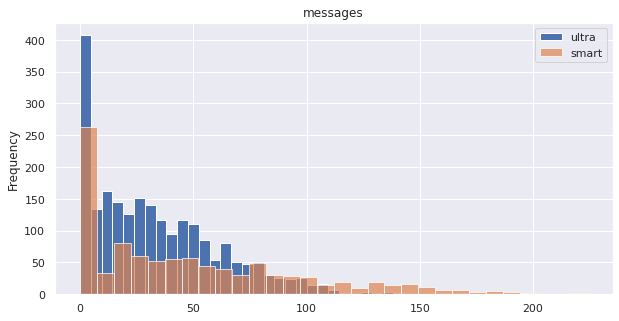

In [81]:
list_of_columns=['duration', 'gb_used', 'messages']
tariffs = ['ultra','smart']
for column in list_of_columns:
        df.loc[df.loc[:,'tariff'] == 'smart'][column].plot( kind = 'hist', bins = 30,label = 'smart', figsize = (10,5))
        df.loc[df.loc[:,'tariff'] == "ultra"][column].plot( kind = 'hist',bins = 30,alpha =0.7,label = 'ultra',figsize = (10,5))
        
        plt.title(column)
        plt.legend(['ultra', 'smart'])
        plt.show()

From the boxplots and diagrams, we can clearly see that **variances and spans are greater for the Ultra** tariff, as well **averages and medians are shifted for the Ultra tariff to a greater extent** than for the Smart tariff. It is also worth noting that ** among the values of the Ultra tariff there are fewer emissions**.

The distributions of call duration and used traffic for both tariffs are close to the normal distribution and relatively symmetrical, but have "heavy" tails. We assume that the distribution of these quantities is **Student's distribution**.

The histogram of the distribution of the number of sent messages has a pronounced **slope to the right **. It is also clearly seen from this histogram that ** the average value is greater than the median **.

Let's find out how the income from the users of the smart tariff changed during the year. Let's create a summary table containing only smart tariff users and group it by month, calculate the median of each month.

In [82]:
monthly_overpayment_smart = df.query('tariff=="smart"').pivot_table(index='month', 
                        values=['total_income'],
                        aggfunc='median')
months = ['Январь', 'Февраль', 'Март', 'Апрель','Май','Июнь','Июль','Август','Сентябрь','Октябрь', 'Ноябрь','Декабрь']
monthly_overpayment_smart['months'] = months

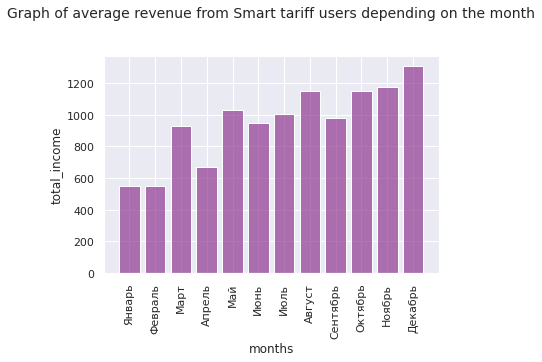

In [83]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# create dataset
total_income = monthly_overpayment_smart['total_income']
months = monthly_overpayment_smart['months']

width = [0.1,0.2,3,1.5,0.3]
x_pos = np.arange(len(months))
 
# Create bars and choose color
plt.bar(x_pos, total_income, color = (0.5,0.1,0.5,0.6))
 
# Add title and axis names

plt.xlabel('months')
plt.ylabel('total_income')
 
# Create names on the x axis
plt.xticks(x_pos, months, rotation=90)

# Create names on the hist
plt.title('Graph of average revenue from Smart tariff users depending on the month\n\n', fontsize=(14))

# Show graph
plt.show()

In [84]:
df.pivot_table(index='tariff', values='total_income', aggfunc='sum')

,total_income
tariff,
smart,2913190.0
ultra,2039100.0


In [85]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

**The Smart tariff** brought the company a profit of **2.9 million rubles** in 2018, while the Ultra tariff ** - 2.04**.

Tariff users **"Smart" - 351 people, and "Ultra" has only 149 users **.

Let's find out if the average revenue rates are equal.

## Output

As a result of data analysis, we were able to calculate the main statistical characteristics for the values of sent messages, the duration of calls and the traffic used. According to these characteristics , the following conclusion can be drawn:

1) On average, a smart user speaks **430 minutes** per month, and an ultra user speaks **532 minutes**.

2) On average, the smart user uses **16.3 gb. of traffic**, and the ultra tariff user uses **19 GB**.

3) On average, the smart user sends **28 messages**, and the user of the ultra tariff - **38** .

The variance of the ultra tariff is greater than that of the smart tariff, which tells us about a larger range of values.

We also built boxplots and histograms of value distributions. The graphs allowed us to make sure that the range of values for all actions of users of the "Ultra" tariff is wider than the range of values of users of the "Smart" tariff. The boxplots clearly illustrated the presence of a large number of emissions from users of the Smart tariff. Perhaps the Ultra tariff could be better suited for these users.

By the end of the year, on average, the user of the Smart tariff began to miss the limits laid down in the tariff, they paid an average of 1200 rubles for communication services in December. for communication services, or to put it more simply, two and a half subscription fees.

The total revenue from all users of the Smart tariff amounted to 2.6 million rubles, while users of the Ultra tariff brought 2.04 million rubles of income. It is also worth analyzing the average revenue from users of these tariffs.

# Hypothesis testing

Let's test the hypothesis that the average revenue from users of the "Smart" tariff is equal to the average revenue from users of the "Ultra" tariff. The null hypothesis will state that the average revenue from tariffs is equal, and the alternative hypothesis will say that the average revenue is different.

H0 - average revenue from users of the "Ultra" tariff is equal to the average revenue from users of the "Smart" tariff"
H1 - average revenue differs훼=0.1% - the level of significance

In [86]:
alpha=.001

In [87]:
smart = df.query('tariff=="smart"')['total_income']
ultra = df.query('tariff=="ultra"')['total_income']

In [88]:
smart

user_id  month
1001     11       1150.0
         12        550.0
1002     6         550.0
         7        1150.0
         8        1550.0
                   ...  
1498     10       1750.0
1499     9         550.0
         10       1150.0
         11       1549.0
         12        613.0
Name: total_income, Length: 2229, dtype: float64

In [89]:
ultra

user_id  month
1000     5        1950.0
         6        1950.0
         7        1950.0
         8        1950.0
         9        1950.0
                   ...  
1495     8        1950.0
         9        2400.0
         10       1950.0
         11       3300.0
         12       1950.0
Name: total_income, Length: 985, dtype: float64

In [90]:
print('Variance of the sample of Smart tariff users:', smart.var(ddof=1))
print('Variance of the sample of Ultra tariff users:', ultra.var(ddof=1))

Variance of the sample of Smart tariff users: 684832.7240895072
Variance of the sample of Ultra tariff users: 141516.7450786183


Let's test the hypothesis using the test_ind function built into the scipy library - which calculates the significance level of the Student's criterion for two independent samples. Since the variances for the samples are very different, it is necessary to take this into account in the function by adding the argument eval_var=False.

In [91]:
results = st.ttest_ind(smart, ultra, equal_var=False) 
print('p:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("It was not possible to reject the null hypothesis")

p: 4.7897104728368674e-238
We reject the null hypothesis


In [92]:
df.pivot_table(index='tariff', values='total_income', aggfunc='mean')

,total_income
tariff,
smart,1306.949305
ultra,2070.152284


Indeed, the table shows that the average revenue differs almost twice

Based on the results of testing the hypothesis, we can also say with 99.9% probability that the average revenue of the user of the "Smart" tariff and the "Ultra" tariff are different.

Let's test the hypothesis that the average revenue from users from Moscow is equal to the average revenue from users from other regions.

H0 - the average revenue from users from Moscow is equal to the average revenue of users from other cities..
H1 - average revenues differ a=0.1% - level of significance 

In [93]:
df = df.join(users.loc[:,['user_id', 'city']].set_index('user_id'), how='outer')

In [94]:
moscow = df.query('city == "Москва"')['total_income']
others = df.query('city != "Москва"')['total_income']

In [95]:
print('Variance of the Moscow user sample:', moscow.var(ddof=1))
print('Дисперсия выборки пользователей остальных городов:', others.var(ddof=1))

Variance of the Moscow user sample: 567709.3186176921
Дисперсия выборки пользователей остальных городов: 659676.7721174321


In [96]:
results = st.ttest_ind(moscow, others, equal_var=False) 
print('p:', results.pvalue)


if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("It was not possible to reject the null hypothesis")

p: 0.5749090668370982
It was not possible to reject the null hypothesis


## Conclusion on statistical analysis

As a result of statistical analysis, we tested two hypotheses with a significance level of a=5% :

1. The first null hypothesis stated that the average revenue from users of the "Smart" tariff and the "Ultra" tariff are equal.
2. The second null hypothesis stated that the average revenue from users from Moscow is equal to the average revenue from users from other cities.

As alternative hypotheses for both cases, we chose the statement that the average revenue will not be equal. To evaluate, we used the significance level of the Student's criterion for independent samples. In this case, we use it, because the average revenue of the samples does not depend on each other.

* In the case of tariffs, we rejected the null hypothesis, and concluded that we can say with 99.9% probability that the average revenue of the user of the "Smart" tariff and the "Ultra" tariff are different
* In the case of cities, we could not reject the null hypothesis.

# General conclusion

For analysis, we were provided with information about the users of the Megaline telecommunications company for 2018. All the necessary information was stored in 5 datasets containing general information about customers, information about the dates and duration of calls, messages sent, Internet sessions and traffic used, as well as general information about the company's tariffs.

The "Ultra" tariff is more promising for the company, at the time of the study, it has much fewer users, but the average revenue that the company's tariff brings is more. Among the users of the Smart tariff, there is a noticeable tendency to increase the consumption of the company's services, which may eventually lead them to a more expensive "Ultra". An increase in the number of users of this tariff could significantly increase the company's revenue. The Smart tariff, on the contrary, shows itself perfectly, at the current parameters. He managed to attract a significant number of users who are forced to pay extra for additional services at higher rates than Ultra users, and thereby generate significant income.